Импорт основных библиотек.
В качестве библиотеки ML выбрана TensorFlow

In [1]:
import tensorflow as tf
import numpy as np
import PIL
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Concatenate, Activation, UpSampling2D, Conv2D, MaxPooling2D, BatchNormalization

Проведем предварительный аналз ДатаСета, 

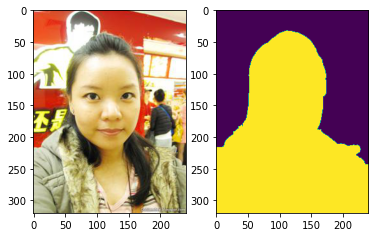

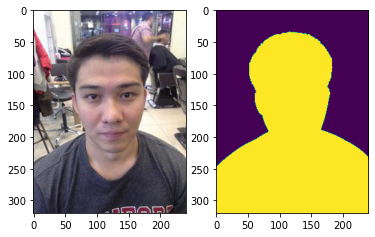

In [2]:
for i in range(2):
    fig, ax = plt.subplots(1,2)
    img = PIL.Image.open(f'./data/train/{i}.jpg')
    mask = PIL.Image.open(f'./data/train_mask/{i}.png')
    ax[0].imshow(img)
    ax[1].imshow(mask)
    plt.show()

In [3]:
# Определим размеры изображений
img = PIL.Image.open('./data/train/0.jpg')
mask = PIL.Image.open('./data/train_mask/0.png')
print(f'Размер основного изображения - {img.size}')
print(f'Размер маски - {mask.size}')

Размер основного изображения - (240, 320)
Размер маски - (240, 320)


Директории расположеия изображений

In [4]:
TRAIN_PATH = "./data/train/"
VALID_PATH = "./data/valid/"

Для создания пайплайна по предварительной обработке воспользуюсь средсвами библиотки TensorFlow. Загрузим список всх изображений (исходных и масок)

In [7]:
# Тренировочный датасет
train_img_ds = tf.data.Dataset.list_files(TRAIN_PATH + '*.jpg', shuffle=False)
# Валидационный датасет
valid_img_ds = tf.data.Dataset.list_files(VALID_PATH + '*.jpg', shuffle=False)

Применение функций для предобработки изображений

In [8]:
from utils import *

train_ds = train_img_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
validation_ds = valid_img_ds.map(preprocess_valid, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.batch(3).prefetch(1)
validation_ds = validation_ds.batch(3).prefetch(1)

Ниже реализована модель нейроннной сети типа UNET. Данная архитектура прозводит кодирование/декодирование изображения.

In [9]:
input_layer = Input(shape=(256, 256, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same', kernel_initializer="he_normal")(input_layer)
conv_1_1 = Activation('relu')(conv_1_1)
conv_1_2 = Conv2D(32, (3, 3), padding='same', kernel_initializer="he_normal")(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)
pool_1 = MaxPooling2D(2)(conv_1_2)

conv_2_1 = Conv2D(64, (3, 3), padding='same', kernel_initializer="he_normal")(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)
conv_2_2 = Conv2D(64, (3, 3), padding='same', kernel_initializer="he_normal")(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)
pool_2 = MaxPooling2D(2)(conv_2_2)

conv_3_1 = Conv2D(128, (3, 3), padding='same', kernel_initializer="he_normal")(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)
conv_3_2 = Conv2D(128, (3, 3), padding='same', kernel_initializer="he_normal")(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)
pool_3 = MaxPooling2D(2)(conv_3_2)

conv_4_1 = Conv2D(256, (3, 3), padding='same', kernel_initializer="he_normal")(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)
conv_4_2 = Conv2D(256, (3, 3), padding='same', kernel_initializer="he_normal")(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)
pool_4 = MaxPooling2D(2)(conv_4_2)

conv_5_1 = Conv2D(512, (3, 3), padding='same', kernel_initializer="he_normal")(pool_4)
conv_5_1 = Activation('relu')(conv_5_1)
conv_5_2 = Conv2D(512, (3, 3), padding='same', kernel_initializer="he_normal")(conv_5_1)
conv_5_2 = Activation('relu')(conv_5_2)
pool_5 = MaxPooling2D(2)(conv_5_2)

conv_6_1 = Conv2D(1024, (3, 3), padding='same', kernel_initializer="he_normal")(pool_5)
conv_6_1 = Activation('relu')(conv_6_1)
conv_6_2 = Conv2D(1024, (3, 3), padding='same', kernel_initializer="he_normal")(conv_6_1)
conv_6_2 = Activation('relu')(conv_6_2)
pool_6 = MaxPooling2D(2)(conv_6_2)

conv_7_1 = Conv2D(2048, (3, 3), padding='same', kernel_initializer="he_normal")(pool_6)
conv_7_1 = Activation('relu')(conv_7_1)
conv_7_2 = Conv2D(2048, (3, 3), padding='same', kernel_initializer="he_normal")(conv_7_1)
conv_7_2 = Activation('relu')(conv_7_2)
pool_7 = MaxPooling2D(2)(conv_7_2)

####
####

up_7 = UpSampling2D(2, interpolation='bilinear')(pool_7)
conc_7 = Concatenate()([conv_7_2, up_7])
conv_up_7_1 = Conv2D(2048, (3, 3), padding='same', kernel_initializer="he_normal")(conc_7)
conv_up_7_1 = Activation('relu')(conv_up_7_1)
conv_up_7_2 = Conv2D(2048, (3, 3), padding='same', kernel_initializer="he_normal")(conv_up_7_1)

up_6 = UpSampling2D(2, interpolation='bilinear')(conv_up_7_2)
conc_6 = Concatenate()([conv_6_2, up_6])
conv_up_6_1 = Conv2D(1024, (3, 3), padding='same', kernel_initializer="he_normal")(conc_6)
conv_up_6_1 = Activation('relu')(conv_up_6_1)
conv_up_6_2 = Conv2D(1024, (3, 3), padding='same', kernel_initializer="he_normal")(conv_up_6_1)

up_5 = UpSampling2D(2, interpolation='bilinear')(conv_up_6_2)
conc_5 = Concatenate()([conv_5_2, up_5])
conv_up_5_1 = Conv2D(256, (3, 3), padding='same', kernel_initializer="he_normal")(conc_5)
conv_up_5_1 = Activation('relu')(conv_up_5_1)
conv_up_5_2 = Conv2D(256, (3, 3), padding='same', kernel_initializer="he_normal")(conv_up_5_1)

up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_5_2)
conc_4 = Concatenate()([conv_4_2, up_4])
conv_up_4_1 = Conv2D(256, (3, 3), padding='same', kernel_initializer="he_normal")(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)
conv_up_4_2 = Conv2D(256, (3, 3), padding='same', kernel_initializer="he_normal")(conv_up_4_1)

up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_4_2)
conc_3 = Concatenate()([conv_3_2, up_3])
conv_up_3_1 = Conv2D(128, (3, 3), padding='same', kernel_initializer="he_normal")(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)
conv_up_3_2 = Conv2D(128, (3, 3), padding='same', kernel_initializer="he_normal")(conv_up_3_1)

up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_2 = Concatenate()([conv_2_2, up_2])
conv_up_2_1 = Conv2D(64, (3, 3), padding='same', kernel_initializer="he_normal")(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)
conv_up_2_2 = Conv2D(64, (3, 3), padding='same', kernel_initializer="he_normal")(conv_up_2_1)

up_1 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_1 = Concatenate()([conv_1_2, up_1])
conv_up_1_1 = Conv2D(32, (3, 3), padding='same', kernel_initializer="he_normal")(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)
conv_up_1_2 = Conv2D(3, (3, 3), padding='same', kernel_initializer="he_normal")(conv_up_1_1)

output_layer = Activation('sigmoid')(conv_up_1_2)
model = Model(inputs=input_layer, outputs=output_layer)

Производится компиляция модели.

In [10]:
model.compile(
    keras.optimizers.Adam(learning_rate=0.001), 
    'binary_crossentropy', 
)

 Добавлены колбэки 

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint('models/unet_best.h5', monitor='loss', verbose=0, save_best_only=True, mode='auto'), 
    keras.callbacks.ModelCheckpoint('models/unet_last.h5', monitor='loss', verbose=0, save_best_only=False, mode='auto')
]

In [ ]:
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=120,
  callbacks=callbacks
)

In [19]:
model = tf.keras.models.load_model("models/unet_best.h5")

In [23]:
imgs = []

for i in [1467,1469,1461,1460,1476,1498,1473,1496,1460,1506,1509,1511,1460,1532,1545,1559]:
    test_img = cv2.imread(f'data/test/{i}.jpg')
    test_img = cv2.resize(test_img, (256, 256), interpolation = cv2.INTER_AREA)
    imgs.append(test_img)

In [24]:
res = model.predict(np.array(imgs))

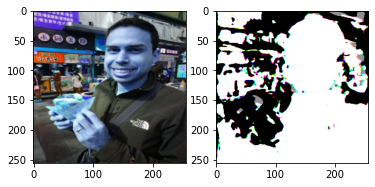

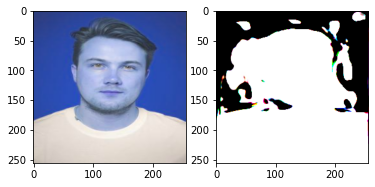

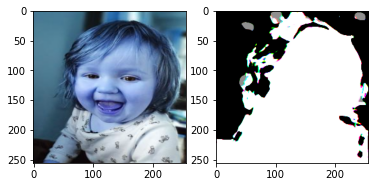

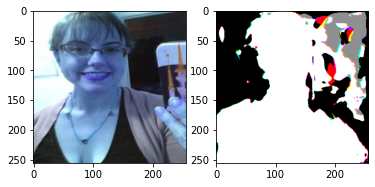

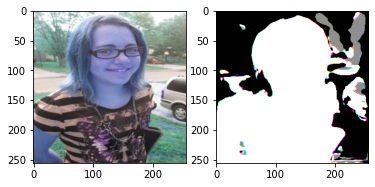

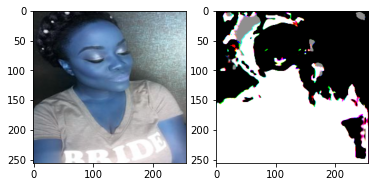

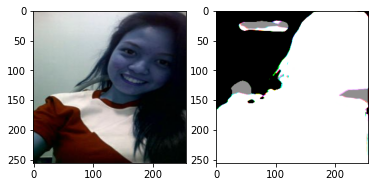

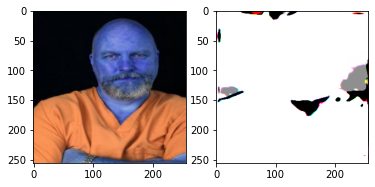

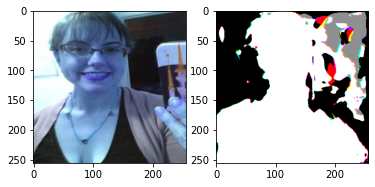

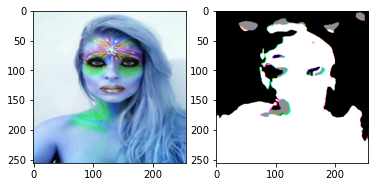

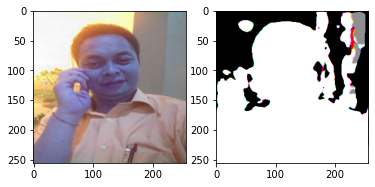

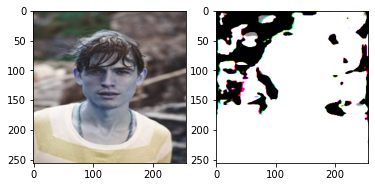

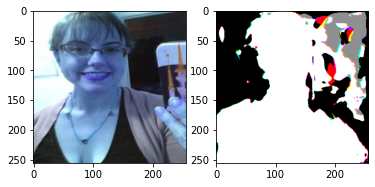

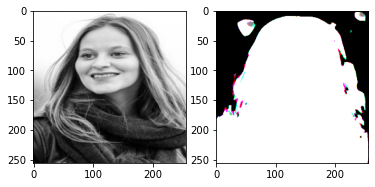

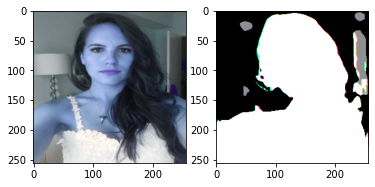

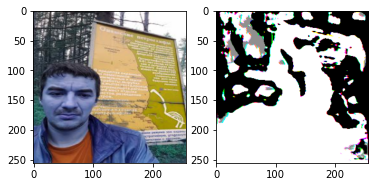

In [25]:
for j in range(len(imgs)):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(imgs[j])
    ax[1].imshow(res[j])
    plt.show()